In [34]:
import os
import time
from typing import Optional

import numpy as np
import pandas as pd
import catboost as cb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from teacher_bot.risk_default_prediction import RiskDefaultPrediction
pd.set_option("display.max_columns", 150)

## Описание задачи

__Задача кредитного скоринга__ – одна из наиболее распространенных задач среди задач бинарной классификации, которые хорошо решаются в бизнесе. Скоринговые модели строятся в разных областях бизнеса, но наиболее известные - это баковская сфера и телеком-операторы. Сегодня, мы разберемся с ключевыми шагами для написания собственной скоринговой модели на `Python`.

Два наиболее важных вопроса кредитования:

* Насколько рискованно поступает заемщик, беря кредит?
* Учитывая известный риск заемщика, должны ли мы его кредитовать?

Определить рискованность действий заемщика можно опираясь на данные об экономическом поведении как его самого, так и результаты кредитования предыдущих заемщиков.

## Для чего нужна скоринговая модель?

Вопрос, который максимально интересует банкиров в вопросе кредитования заемщиков — это сможет ли заемщик вернуть кредит. Соответственно, все модели будут пытаться предугадать вероятность возврата (или дефолта) данного заемщика на основе имеющихся факторов и данных. В реальной жизни при построении моделей маишнного обучения мы сталкиваемся с неполными данными, поэтому нужно обратить особое внимание на два момента:

* Что делать, если часть данных отсутствует?
* Как строить модели для несбалансированных выборок?
* Как объединить данные из разных источников?
* Как объединить дублирующие данные?

Будем работать с реальными данными, которые мы рассматривали в уроке про создание новых признаков. В данной задаче, мы имеем несколько разных источников данных:

* `application.csv` - данные из анкеты клиента;
* `previous_application.csv` - данные из предыдущих анкет клиентов (исторические заявки);
* `installments_payments.csv` - история совершенных платежей по кредитам;
* `bureau.csv` - данные, полученные из бюро кредитных историй;
* `bureau_balance.csv` - данные, полученные из бюро кредитный историй (информация по балансам);
* `credit_card_balance.csv` - история балансов на кредитных картах;
* `POS_CASH_balance.csv` - история балансов на кредитах POS / CASH.

Задача состоит в том, на обучающих данных и данных из источников необходимо построить модель, определяющую вероятность «дефолта», и применить эту модель на данные из тестовой выборки.. Для оценки модели будет использоваться характеристика __Area Under ROC Curve__. Это традиционная метрика качества, которая по умолчанию выбирается в задаче кредитного скоринга.

In [ ]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "./data/"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

def check_missings(X: pd.DataFrame):
    """
    Вычисление количества пропусков и пропусков в данных;

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков для исследования.

    Returns
    -------
    na_stats: pandas.core.frame.DataFrame
        Матрица с со статистикой пропусков.
    
    """
    total = X.isnull().sum().sort_values(ascending = False)
    percent = (X.isnull().sum()/X.isnull().count()*100).sort_values(ascending = False)
    na_stats = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return na_stats.T


def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title=''):
    """
    Визуализация распределения значений категориального признака.

    """
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values, palette="viridis")
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
        
        
def plot_kde_target(feature_name: str, data: pd.DataFrame):
    """
    Визуализация функции распределения признаков в зависимости
    от значения целевой переменной на обучающей выборке.
    Вывод коэффициента корреляции между значением признака
    и значением целевой переменной, вывод медианы
    значений признака в разрезе целевой переменной.

    Parameters
    ----------
    faeture_name: str
        Название анализируемого признака.

    data: pandas.core.frame.DataFrame
        Матрица признаков для обучения.

    """
    corr = data["target"].corr(data[feature_name])

    mask = data["target"] == 1
    avg_target = data.loc[mask, feature_name].median()
    avg_non_target = data.loc[~mask, feature_name].median()

    fig = plt.figure(figsize=(12, 6))
    plt.title(f"{feature_name} Distribution", size=14)
    sns.kdeplot(data.loc[mask, feature_name], linewidth=3, color="blue", label="TARGET = 1")
    sns.kdeplot(data.loc[~mask, feature_name], linewidth=3, color="green", label="TARGET = 0")
    plt.legend(loc="best", fontsize=14)
    plt.xlabel(feature_name, size=14)
    plt.ylabel("Density", size=14)

    print(f"The correlation between {feature_name} and target = {round(corr, 4)}")
    print(f"Median-value for default-loan = {round(avg_target, 4)}")
    print(f"Median-value for non default-loan = {round(avg_target, 4)}")


def catboost_hold_out_validation(params, X, y, split_params = [0.7, 0.2, 0.1], categorical = None):
    """
    Hold-Out валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    split_params: List[float], optional, default = [0.7, 0.2, 0.1]
        Параметры (доли) разбиения выборки.
        Опциональный параметр, по умолчанию, равен [0.7, 0.2, 0.1].
    
    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimator: catboost.core.CatBoostClassifier
        Обученный классификатор catboost.

    test_prediction: np.array, optional
        Вектор прогнозов для тестовой выборки.
        Опциональный объект, возвращается только, если split_params
        содержит 3 значения.

    """
    print(f"Starting at {time.ctime()}")
    numeric = list(set(X.columns) - set(categorical))
    if categorical:
        X[categorical] = X[categorical].astype(str)

    x_train, x_valid = train_test_split(
        X, train_size=split_params[0], random_state=27
    )
    y_train, y_valid = train_test_split(
        y, train_size=split_params[0], random_state=27
    )

    if len(split_params) == 3:
        test_size = int(split_params[2] * X.shape[0])

        x_valid, x_test = train_test_split(
            x_valid, test_size=test_size, random_state=72
        )
        y_valid, y_test = train_test_split(
            y_valid, test_size=test_size, random_state=72
        )

    model = cb.CatBoostClassifier(**params)
    model.fit(
        x_train, y_train, categorical,
        eval_set=[(x_train, y_train), (x_valid, y_valid)]
    )

    print("="*80)
    valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
    print(f"Valid Score = {round(valid_score, 4)}")

    if len(split_params) == 3:

        test_prediction = model.predict_proba(x_test)[:, 1]
        test_score = roc_auc_score(y_test, test_prediction)
        print(f"Test Score = {round(test_score, 4)}")

        return model, test_prediction

    else:
        return model


def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [35]:
train = get_input("train.csv")
test = get_input("test.csv")
train.head(n=2)

train.csv: shape = 215257 rows, 122 cols
test.csv: shape = 92254 rows, 121 cols


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.007120,-14937,-5026,-1.0,-4606,NaN,1,1,0,1,0,0,Managers,2.0,2,2,FRIDAY,10,0,0,0,0,0,0,Government,NaN,0.612914,0.408359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-797.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0
1,183133,0,Cash loans,F,N,Y,0,112500.0,656811.0,30564.0,567000.0,"Spouse, partner",Pensioner,Secondary / secondary special,Married,House / apartment,0.016612,-22021,365243,-2979.0,-5036,NaN,1,0,0,1,0,0,NaN,2.0,2,2,MONDAY,11,0,0,0,0,0,0,XNA,NaN,0.703983,0.755740,0.3711,0.2556,0.9955,0.9388,NaN,0.36,0.3103,0.375,NaN,0.0,NaN,0.3977,NaN,0.0,0.3782,0.2653,0.9955,0.9412,NaN,0.3625,0.3103,0.375,NaN,0.0,NaN,0.4144,NaN,0.0,0.3747,0.2556,0.9955,0.9396,NaN,0.36,0.3103,0.375,NaN,0.0,NaN,0.4049,NaN,0.0,NaN,block of flats,0.3983,Panel,No,4.0,0.0,4.0,0.0,-1542.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [36]:
applications = get_input("previous_application.csv")
applications.head(n=2)

previous_application.csv: shape = 1670214 rows, 37 cols


,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


In [37]:
payments = get_input("installments_payments.csv")
payments.head(n=2)

installments_payments.csv: shape = 13605401 rows, 8 cols


,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525


In [38]:
bureau = get_input("bureau.csv")
bureau.head(n=2)

bureau.csv: shape = 1716428 rows, 17 cols


,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN


In [39]:
bureau_balance = get_input("bureau_balance.csv")
bureau_balance.head(n=2)

bureau_balance.csv: shape = 27299925 rows, 3 cols


,sk_id_bureau,months_balance,status
0,5715448,0,C
1,5715448,-1,C


In [40]:
credit_card_balance = get_input("credit_card_balance.csv")
credit_card_balance.head(n=2)

credit_card_balance.csv: shape = 3840312 rows, 23 cols


,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,amt_payment_current,amt_payment_total_current,amt_receivable_principal,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.00,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.08,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0


In [41]:
balance = get_input("POS_CASH_balance.csv")
balance.head(n=2)

POS_CASH_balance.csv: shape = 10001358 rows, 8 cols


,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


## Exploration Data Analysis

## Проверка наличия выбросов

In [42]:
check_missings(train)

,commonarea_medi,commonarea_avg,commonarea_mode,nonlivingapartments_mode,nonlivingapartments_medi,nonlivingapartments_avg,fondkapremont_mode,livingapartments_medi,livingapartments_mode,livingapartments_avg,floorsmin_medi,floorsmin_mode,floorsmin_avg,years_build_medi,years_build_avg,years_build_mode,own_car_age,landarea_mode,landarea_avg,landarea_medi,basementarea_medi,basementarea_avg,basementarea_mode,ext_source_1,nonlivingarea_medi,nonlivingarea_avg,nonlivingarea_mode,elevators_mode,elevators_avg,elevators_medi,wallsmaterial_mode,apartments_mode,apartments_avg,apartments_medi,entrances_medi,entrances_mode,entrances_avg,livingarea_medi,livingarea_mode,livingarea_avg,housetype_mode,floorsmax_mode,floorsmax_medi,floorsmax_avg,years_beginexpluatation_medi,years_beginexpluatation_avg,years_beginexpluatation_mode,totalarea_mode,emergencystate_mode,occupation_type,ext_source_3,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_day,amt_req_credit_bureau_hour,name_type_suite,obs_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,def_30_cnt_social_circle,ext_source_2,amt_goods_price,amt_annuity,cnt_fam_members,days_last_phone_change,amt_credit,flag_own_car,flag_email,target,flag_phone,flag_cont_mobile,flag_work_phone,flag_emp_phone,flag_mobil,name_contract_type,code_gender,flag_own_realty,amt_income_total,days_id_publish,days_registration,days_employed,days_birth,region_population_relative,region_rating_client,name_family_status,name_education_type,name_income_type,cnt_children,name_housing_type,reg_region_not_live_region,region_rating_client_w_city,weekday_appr_process_start,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,organization_type,live_city_not_work_city,reg_city_not_work_city,reg_city_not_live_city,live_region_not_work_region,reg_region_not_work_region,hour_appr_process_start,sk_id_curr
Total,150190.000000,150190.000000,150190.000000,149242.000000,149242.000000,149242.000000,147039.00000,146907.000000,146907.000000,146907.000000,145871.000000,145871.000000,145871.000000,142971.000000,142971.000000,142971.000000,142032.000000,127551.000000,127551.000000,127551.000000,125853.000000,125853.000000,125853.000000,121544.000000,118586.000000,118586.000000,118586.000000,114613.000000,114613.000000,114613.000000,109287.000000,109109.000000,109109.000000,109109.000000,108238.00000,108238.00000,108238.00000,107948.000000,107948.000000,107948.000000,107887.000000,106994.000000,106994.000000,106994.000000,104912.00000,104912.00000,104912.00000,103847.000000,101981.000000,67601.000000,42683.000000,29182.000000,29182.000000,29182.000000,29182.000000,29182.000000,29182.000000,904.000000,709.000000,709.000000,709.000000,709.000000,459.000000,197.000000,10.000000,2.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,69.772412,69.772412,69.772412,69.332008,69.332008,69.332008,68.30858,68.247258,68.247258,68.247258,67.765973,67.765973,67.765973,66.418746,66.418746,66.418746,65.982523,59.255216,59.255216,59.255216,58.466391,58.466391,58.466391,56.464598,55.090427,55.090427,55.090427,53.244726,53.244726,53.244726,50.770474,50.687783,50.687783,50.687783,50.28315,50.28315,50.28315,50.148427,50.148427,50.148427,50.120089,49.705236,49.705236,49.705236,48.73802,48.73802,48.73802,48.243263,47.376392,31.404786,19.828856,13.556818,13.556818,13.556818,13.556818,13.556818,13.556818,0.419963,0.329374,0.329374,0.329374,0.329374,0.213233,0.091519,0.004646,0.000929,0.000465,0.0,0.0,0.0,0.0,0.0,0.0

In [43]:
check_missings(applications)

,rate_interest_privileged,rate_interest_primary,rate_down_payment,amt_down_payment,name_type_suite,days_termination,nflag_insured_on_approval,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,amt_goods_price,amt_annuity,cnt_payment,product_combination,amt_credit,sk_id_curr,name_contract_type,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,amt_application,name_payment_type,name_cash_loan_purpose,name_contract_status,days_decision,code_reject_reason,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,name_yield_group,sk_id_prev
Total,1.664263e+06,1.664263e+06,895844.00000,895844.00000,820405.000000,673065.000000,673065.000000,673065.000000,673065.000000,673065.000000,673065.000000,385515.000000,372235.000000,372230.000000,346.000000,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,9.964370e+01,9.964370e+01,53.63648,53.63648,49.119754,40.298129,40.298129,40.298129,40.298129,40.298129,40.298129,23.081773,22.286665,22.286366,0.020716,0.00006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
check_missings(payments)

,amt_payment,days_entry_payment,amt_instalment,days_instalment,num_instalment_number,num_instalment_version,sk_id_curr,sk_id_prev
Total,2905.000000,2905.000000,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.021352,0.021352,0.0,0.0,0.0,0.0,0.0,0.0


## Визуализация категориальных признаков

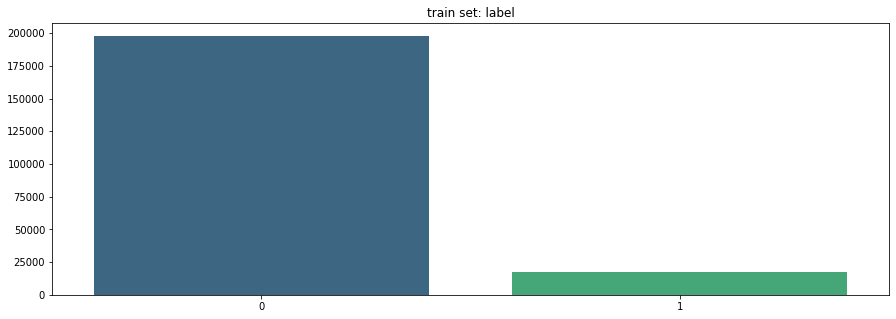

In [45]:
plot_categorical(
    data=train, col='target', size=[15, 5], xlabel_angle=0, title='train set: label')

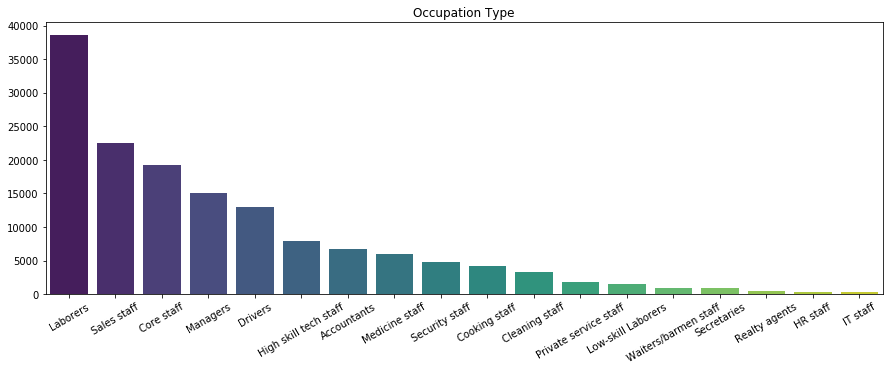

In [46]:
plot_categorical(
    data=train, col='occupation_type', size=[15, 5], xlabel_angle=30, title='Occupation Type')

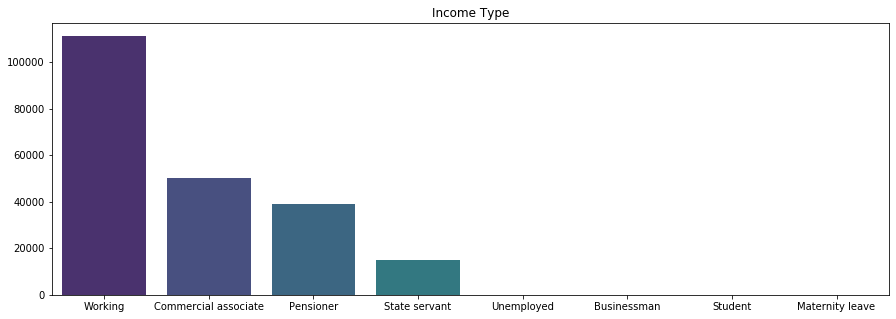

In [47]:
plot_categorical(
    data=train, col='name_income_type', size=[15, 5], xlabel_angle=0, title='Income Type')

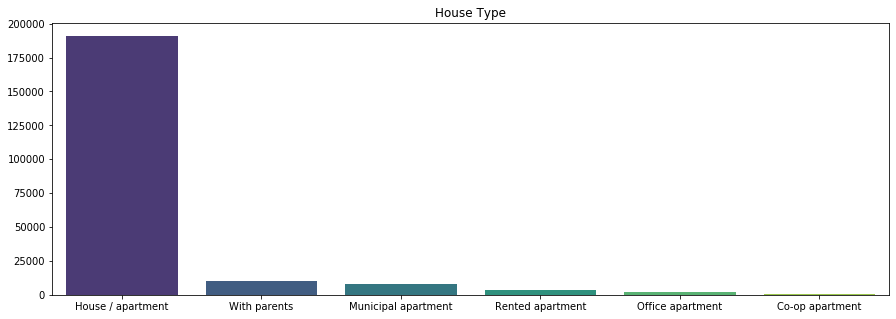

In [48]:
plot_categorical(
    data=train, col='name_housing_type', size=[15, 5], xlabel_angle=0, title='House Type')

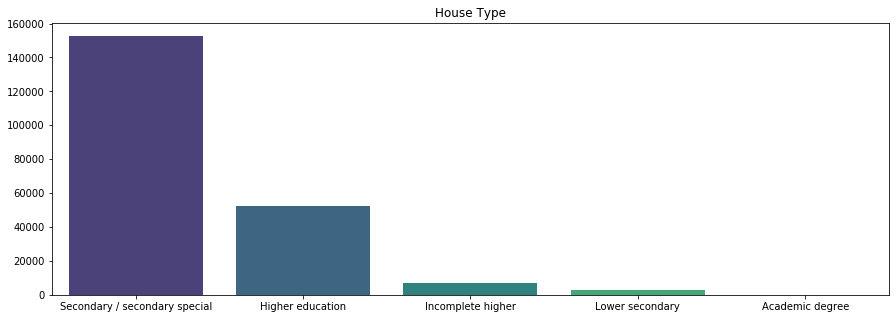

In [49]:
plot_categorical(
    data=train, col='name_education_type', size=[15, 5], xlabel_angle=0, title='House Type')

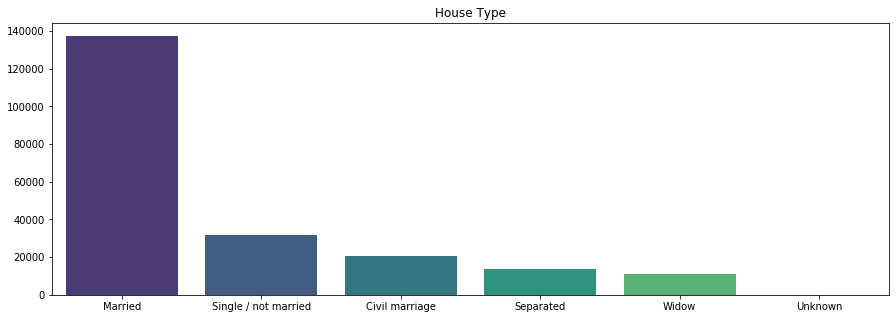

In [50]:
plot_categorical(
    data=train, col='name_family_status', size=[15, 5], xlabel_angle=0, title='House Type')

## Визуализация числовых признаков

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


The correlation between amt_annuity and target = -0.0118
Median-value for default-loan = 25195.5
Median-value for non default-loan = 25195.5


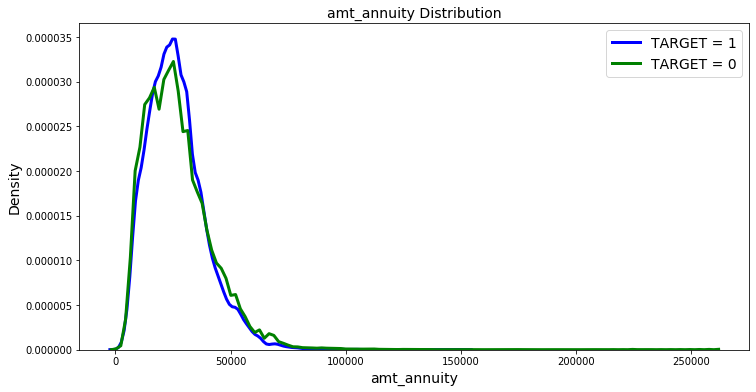

In [51]:
plot_kde_target(
    feature_name="amt_annuity", data=train
)

The correlation between amt_goods_price and target = -0.0378
Median-value for default-loan = 450000.0
Median-value for non default-loan = 450000.0


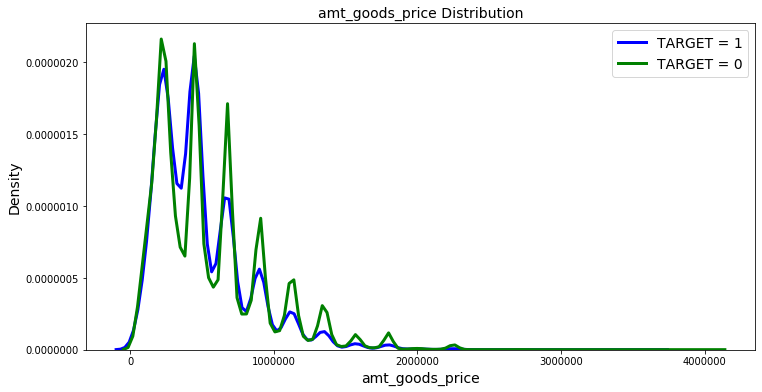

In [52]:
plot_kde_target(
    feature_name="amt_goods_price", data=train
)

The correlation between cnt_fam_members and target = 0.0093
Median-value for default-loan = 2.0
Median-value for non default-loan = 2.0


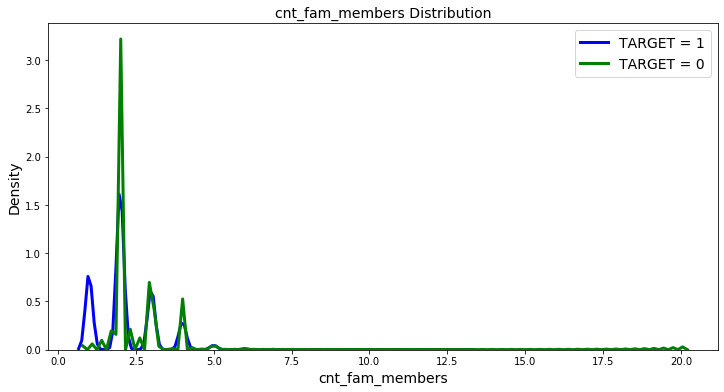

In [53]:
plot_kde_target(
    feature_name="cnt_fam_members", data=train
)

The correlation between ext_source_1 and target = -0.1561
Median-value for default-loan = 0.3604
Median-value for non default-loan = 0.3604


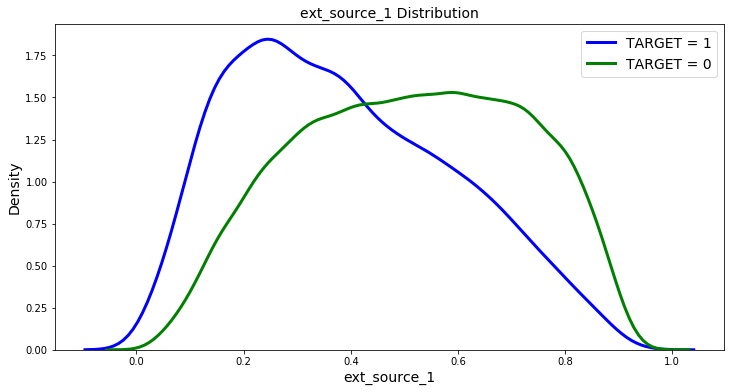

In [54]:
plot_kde_target(
    feature_name="ext_source_1", data=train
)

The correlation between ext_source_2 and target = -0.1585
Median-value for default-loan = 0.4404
Median-value for non default-loan = 0.4404


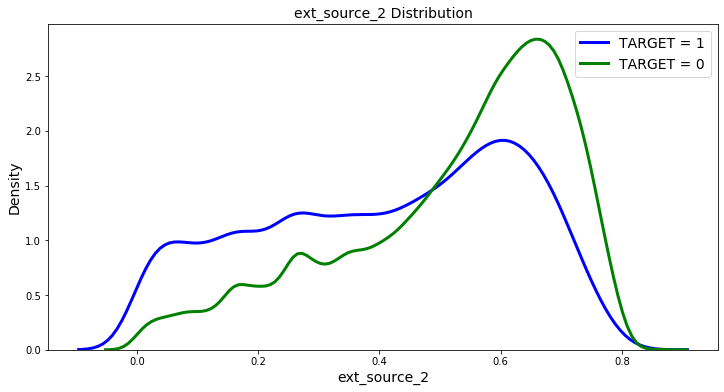

In [55]:
plot_kde_target(
    feature_name="ext_source_2", data=train
)

The correlation between ext_source_3 and target = -0.178
Median-value for default-loan = 0.3825
Median-value for non default-loan = 0.3825


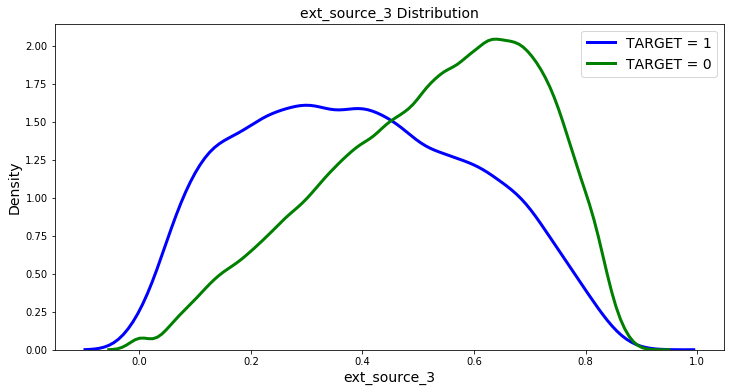

In [56]:
plot_kde_target(
    feature_name="ext_source_3", data=train
)

## Анализ источников данных

In [57]:
n_clients = applications["sk_id_curr"].nunique()

print(f"Applications: {applications.shape[0]} rows")
print(f"Unique clients: {n_clients}")

Applications: 1670214 rows
Unique clients: 338857


In [58]:
n_clients = payments["sk_id_curr"].nunique()

print(f"payments: {payments.shape[0]} rows")
print(f"Unique clients: {n_clients}")

payments: 13605401 rows
Unique clients: 339587


In [59]:
n_clients = bureau["sk_id_curr"].nunique()

print(f"credit history bureau: {bureau.shape[0]} rows")
print(f"Unique clients: {n_clients}")

credit history bureau: 1716428 rows
Unique clients: 305811


## Построение baseline-модели

In [60]:
y_train = train["target"]
X_train = train.drop(["target", "sk_id_curr"], axis=1)
categorical = X_train.dtypes[X_train.dtypes == "object"]
categorical = list(categorical.index)

In [61]:
cb_params = {
    "n_estimators": 500,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "verbose": 25,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

estimators, prediction = catboost_hold_out_validation(
    params=cb_params, X=X_train, y=y_train, split_params=[0.6, 0.2, 0.2], categorical=categorical
)

Starting at Thu Oct 22 22:10:22 2020
0:	test: 0.6317760	test1: 0.6336536	best: 0.6336536 (0)	total: 231ms	remaining: 1m 55s
25:	test: 0.7073973	test1: 0.7084651	best: 0.7094537 (23)	total: 6.57s	remaining: 1m 59s
50:	test: 0.7119203	test1: 0.7135714	best: 0.7139202 (46)	total: 12.4s	remaining: 1m 49s
75:	test: 0.7145974	test1: 0.7161652	best: 0.7162163 (72)	total: 18.2s	remaining: 1m 41s
100:	test: 0.7169627	test1: 0.7185299	best: 0.7186969 (94)	total: 24.4s	remaining: 1m 36s
125:	test: 0.7207189	test1: 0.7219763	best: 0.7219763 (125)	total: 30.2s	remaining: 1m 29s
150:	test: 0.7246853	test1: 0.7258410	best: 0.7258410 (150)	total: 35.9s	remaining: 1m 22s
175:	test: 0.7293156	test1: 0.7304488	best: 0.7304488 (175)	total: 42s	remaining: 1m 17s
200:	test: 0.7328684	test1: 0.7335751	best: 0.7335751 (200)	total: 48.3s	remaining: 1m 11s
225:	test: 0.7355929	test1: 0.7358353	best: 0.7358353 (225)	total: 55.4s	remaining: 1m 7s
250:	test: 0.7382042	test1: 0.7379849	best: 0.7379849 (250)	total: 

## Прогнозирование и проверка качества

In [63]:
test[categorical] = test[categorical].astype(str)
prediction = estimators.predict_proba(test.drop("sk_id_curr", axis=1))[:, 1]

submit = pd.DataFrame({
    "sk_id_curr": test["sk_id_curr"],
    "score": prediction
})
submit.head(n=3)

,sk_id_curr,score
0,174545,0.036014
1,209898,0.077071
2,454938,0.052982


In [64]:
bot = RiskDefaultPrediction()
bot.production_quality(answer=submit)

Привет! Приятно познакомиться!
Запускаю тестирование...
Проверяю метрики...
Твой результат: 0.755768674888305
Думаю...
Если ты используешь бустинг, то все реализации ты попробовал? LightGBM? XGBoost? CatBoost?
Нужно качество больше 0.77, я верю - у тебя получится!
